In [1]:

# Don't use Kale on this one.
import pendulum
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, BatchNormalization, Lambda
from tensorflow.keras.regularizers import l1,l2, L1L2
import matplotlib.pyplot as plt
from scipy import stats


2023-01-05 21:21:20.751703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 21:21:20.895255: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 21:21:20.899185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 21:21:20.899205: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Get the best params from Katib from running the first notebook with Kale 
![assets/x002-final-results-page.png](assets/x002-final-results-page.png)

In [20]:
# Get the best params from Katib from running the first notebook with Kale 
data_file_to_run = "IMP_height.txt"

experiment_description = "Soy Height GWAS"

learning_rate = 0.000036 # 0.0001957
conv_1_dropout_rate = 0.60 # Dropout rate for first convolutional layer
conv_1_kernel_l1 = 0.0000007 # L1 and l2 regularization for the first conv1d layer's weights
conv_1_kernel_l2 = 0.00045
conv_1_bias_l2 = 0.000064 # L1 and l2 regularization for the first conv1d layer's bias
conv_1_activity_l2 = 0.004 # L1 and l2 activity  regularization for the first conv1d layer

conv_x_kernel_l1 = 0.7
conv_x_kernel_l2 = 0.14
conv_x_bias_l2 = 0.007
conv_x_activity_l2 = 0.000005

dense_x_kernel_l1 = 0.018
dense_x_kernel_l2 = 0.0000015
dense_x_bias_l2 = 0.0017
dense_x_activity_l2 = 0.0005

dense_out_kernel_l1 = 0.0000007
dense_out_kernel_l2 = .0000024
dense_out_bias_l2 = 0.023
dense_out_activity_l2 = 0.024

conv_initializer = 'glorot_uniform' # 'TruncatedNormal' 'TruncatedNormal' 'glorot_uniform'  "GlorotNormal",  "HeNormal" 'random_normal'  
dese_initializer = 'HeNormal' # "GlorotNormal" # 'TruncatedNormal' # "GlorotUniform"

dropout_rate = 0.055
num_dense_layers = 3
num_dense_units = 13

conv_activation = "gelu" # "linear"
activation = "linear"
loss = 'mean_squared_error' # 'mean_absolute_error' #  # 'huber_loss'  

final_activation_scale_factor = 2.12

batch_size = 25
epochs = 15

time = pendulum.now(tz='America/New_York').__str__()[:16].replace('T','').replace(':','').replace('_','-')


In [3]:
# Don't run in kale this time

ht = pd.read_csv(data_file_to_run, sep = '\t')
ht_pd = ht_relevant_cols = ht.drop(columns = ['strain', 'height', 'folds'])
phenotypes_norm = ht_pd.pop("norm_phe")
for col in ht_pd.columns:
    ht_pd[col] = ht_pd[col].astype('category')
ohe_height_genotypes = pd.get_dummies(ht_pd)

def train_test_splitting(row, split_ratio):
    string_of_row = "".join([str(l) for l in list(row.values)])
    return (abs(hash(string_of_row)) % 10) / 10 < split_ratio
belongs_in_train_set_index =\
    np.array([train_test_splitting(ohe_height_genotypes.loc[i],0.7)
     for i in np.arange(ht_pd.shape[0])])

train_ohe_height_genotypes = ohe_height_genotypes[belongs_in_train_set_index]
val_ohe_height_genotypes = ohe_height_genotypes[~belongs_in_train_set_index]

train_phenotypes_norm = phenotypes_norm[belongs_in_train_set_index]
val_phenotypes_norm = phenotypes_norm[~belongs_in_train_set_index]

# Make sure the number of rows in test and train add up to the original rows
assert train_ohe_height_genotypes.shape[0] + val_ohe_height_genotypes.shape[0] == ht_pd.shape[0]

# Data as a numpy array...
train_ohe_height_genotypes_np = train_ohe_height_genotypes.values
val_ohe_height_genotypes_np = val_ohe_height_genotypes.values

train_phenotypes_norm_np = train_phenotypes_norm.values
val_phenotypes_norm_np = val_phenotypes_norm.values

# Reshape to fit the conv1D network. 
train_np_ohe_reshaped_for_conv_1_d =\
    train_ohe_height_genotypes_np.reshape((train_ohe_height_genotypes_np.shape[0],
                                          train_ohe_height_genotypes_np.shape[1], 1))
val_np_ohe_reshaped_for_conv_1_d =\
    val_ohe_height_genotypes_np.reshape((val_ohe_height_genotypes_np.shape[0],
                                        val_ohe_height_genotypes_np.shape[1],1))

np.save('train_data_ready', train_np_ohe_reshaped_for_conv_1_d)
np.save('val_data_ready', val_np_ohe_reshaped_for_conv_1_d)
np.save('train_labels_ready', train_phenotypes_norm_np)
np.save('val_labels_ready',val_phenotypes_norm_np)

# Since the data was reshaped for the convolutional 1D neural network, we are also saving the 
# non-reshaped data to be used for calculating saliency.

np.save("val_snps_for_saliency", val_ohe_height_genotypes_np)

print("Preprocessing successful")


Preprocessing successful


Epoch 1/15
145/145 [==============================] - 55s 343ms/step - loss: 184.9438 - mean_absolute_error: 1.1132 - val_loss: 145.5629 - val_mean_absolute_error: 0.7159
Epoch 2/15
145/145 [==============================] - 53s 366ms/step - loss: 134.6771 - mean_absolute_error: 1.0567 - val_loss: 127.3722 - val_mean_absolute_error: 0.7289


INFO:tensorflow:Assets written to: a-2023-01-051641-model/assets


INFO:tensorflow:Assets written to: a-2023-01-051641-model/assets


a-2023-01-051641-model


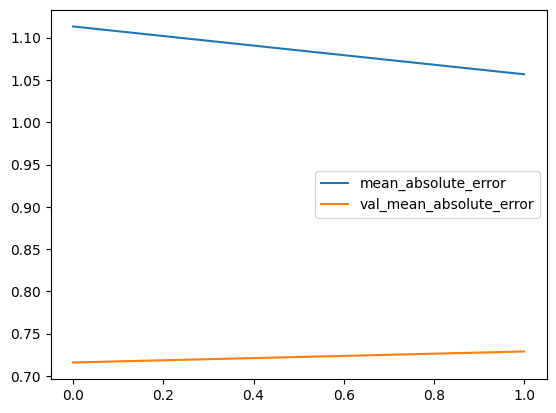

In [21]:
# Don't run in Kale this time
nb_classes = 3

data_files = ['./train_data_ready.npy',
              "./val_data_ready.npy",
              "./train_labels_ready.npy",
              "./val_labels_ready.npy"]
# artifact_bucket_root_name = artifacts_bucket.split('/')[-1]
# print(artifact_bucket_root_name)
# storage_client = storage.Client()
# bucket = storage_client.get_bucket(artifact_bucket_root_name)

ht_np_train = np.load('train_data_ready.npy', allow_pickle=True)
ht_np_val = np.load('val_data_ready.npy', allow_pickle=True)
train_labels_np = np.load('train_labels_ready.npy', allow_pickle=True)
val_labels_np = np.load('val_labels_ready.npy', allow_pickle=True)

train_snps = ht_np_train
train_phenotypes = train_labels_np
val_snps = ht_np_val
val_phenotypes = val_labels_np

# print("min")
# print(val_phenotypes.min())
# print("max")
# print(val_phenotypes.max())

inputs =\
    tf.keras.layers.Input(
        shape=(train_snps.shape[1], 
               train_snps.shape[2])) # train_snps.shape[1] ,nb_classes))

x = Conv1D(10,
           nb_classes,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_1_kernel_l1, l2=conv_1_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_1_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_1_activity_l2)
          )(inputs)

           # kernel_initializer = conv_initializer ,
           # kernel_regularizer="l2", bias_regularizer = "l2")
x = Dropout(conv_1_dropout_rate)(x)

x = Conv1D(10,
           20,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2)
           # kernel_initializer = 'TruncatedNormal',
           # kernel_regularizer="l2",
           # bias_regularizer="l2"
          )(x) # Leaving l1 l2 on head layer only to see if this prevents everything from zeroing out.

x = Dropout(dropout_rate)(x)


shortcut = Conv1D(10,
                  4,
                  padding='same',
                  activation = conv_activation,
                  kernel_initializer = conv_initializer,
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
                  bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
                  activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2))(inputs)
shortcut = Dropout(dropout_rate)(shortcut)
x = tf.keras.layers.Add()([shortcut,x])

x = Conv1D(10,
           4,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2)
           # kernel_initializer = 'TruncatedNormal', 
           # kernel_regularizer = "l2",
           # bias_regularizer = "l2"
          )(x)

# x = Dropout(dropout_rate)(x)

x = Flatten()(x)
# x = Dropout(dropout_rate)(x)
x = BatchNormalization()(x)

if num_dense_layers > 0:
    y = x
    for i in np.arange(num_dense_layers):
        y = Dense(num_dense_units, 
                  activation,
                  kernel_initializer=dese_initializer,
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=dense_x_kernel_l1, l2=dense_x_kernel_l2),
                  bias_regularizer=tf.keras.regularizers.L2(dense_x_bias_l2),
                  activity_regularizer=tf.keras.regularizers.L2(dense_x_activity_l2)
                  )(y)
        # y = Dropout(dropout_rate)(y)
        y = BatchNormalization()(y)
        
    x = tf.keras.layers.Concatenate(axis=1)([x,y])
    x = BatchNormalization()(x)

outputs_unscaled = Dense(1,
                activation="softsign",
                kernel_initializer=dese_initializer,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=dense_out_kernel_l1, l2=dense_out_kernel_l2),
                bias_regularizer=tf.keras.regularizers.L2(dense_out_bias_l2),
                activity_regularizer=tf.keras.regularizers.L2(dense_out_activity_l2),
                # bias_regularizer = "l2",
                # kernel_initializer = 'TruncatedNormal',
                name = 'out')(x) # Should have no activation
# Softsign coerces the output to the range {-1,1}. The labels are norm scaled, 
# where the range {-2,2} or {-3,3} encompasses most values. We multiply by a scalar 
# and the range will terminate at +/- said scalar. No telling which one is optimal,
# so we'll le the the tuner figure out what: 
outputs = Lambda(lambda x: x * final_activation_scale_factor)(outputs_unscaled) 

our_data_model = Model(inputs = inputs, outputs = outputs)
# qa_data_model = Model(inputs = inputs, outputs = outputs)
our_data_model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError()],
              jit_compile=True)

# We added the early stopping callback and instructed it to restore the best weights. 
callbacks = [tf.keras.callbacks.EarlyStopping(restore_best_weights=True)]

history =\
    our_data_model.fit(x = train_snps,
                       y = train_phenotypes,
                       callbacks = callbacks,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(val_snps, val_phenotypes),
                       shuffle= True,
                       use_multiprocessing=True)
# Requirement 6: save and log your artifact. 
# I'm adding a random number to the file name as an
# extra layer of safety nets against race conditions
# / file name conflicts

# tn = str(int(np.random.random() * 10 ** 12))
model_folder = f"a-{time}-model"
our_data_model.save(model_folder)

history_df = pd.DataFrame(history.history)

history_df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.savefig(f'{model_folder}-history.png')

print(model_folder)

val_mean_absolute_error = float(history_df['val_mean_absolute_error'].values.min())



In [5]:


# Calculate observed p values: 

val_snps_s = np.load("val_snps_for_saliency.npy", allow_pickle=True)
val_phenotypes_k = np.load('val_labels_ready.npy', allow_pickle=True)

p_values = []
for i in np.arange(int(val_snps_s.shape[1] / 3)):
    column_index_lower_bound = 3 * i
    column_index_upper_bound = 3 * i + 3
    data = val_snps_s[:,column_index_lower_bound:column_index_upper_bound]
    data_reshaped = np.argmax(data, axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_reshaped, val_phenotypes_k)
    p_values.append(p_value)
p_values_observed_np = np.array(p_values)
np.save('p_values_observed_np', 
        p_values_observed_np, 
        allow_pickle=True)




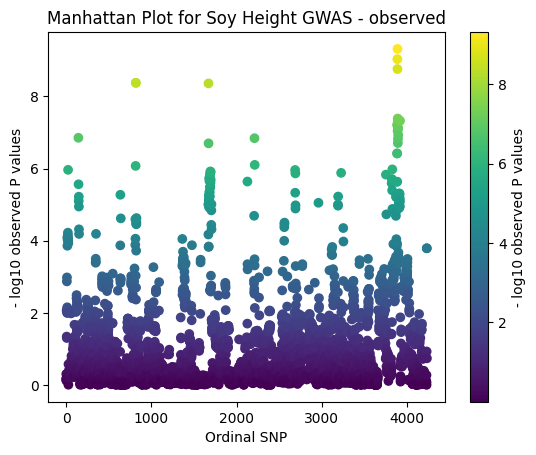

In [6]:


model_folder = f"a-{time}-model"
p_values_observed_np = np.load('p_values_observed_np.npy',
                               allow_pickle=True)

neg_log = -1 * np.log10(p_values_observed_np)
slug = np.arange(p_values_observed_np.shape[0])

pt = plt.scatter(x = slug, y = neg_log, c=neg_log)
plt.title(f"Manhattan Plot for {experiment_description} - observed")
plt.xlabel("Ordinal SNP")
plt.ylabel("- log10 observed P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 observed P values")
plt.savefig(f"{model_folder}-manhattan-observed")


In [22]:


val_snps_s = np.load("val_snps_for_saliency.npy", allow_pickle=True)
model_folder = f"a-{time}-model"

def get_saved_model(final_activation_scale_factor: float, model_folder: str):
    final_model = tf.keras.models.load_model(model_folder)
    for layer in final_model.layers:
        layer.trainable=False
    return final_model
    # print(layer.weights)

final_model = get_saved_model(final_activation_scale_factor=final_activation_scale_factor, model_folder = model_folder)
val_phenotypes_p = final_model.predict(val_snps_s).flatten()

p_values_p = []
for i in np.arange(int(val_snps_s.shape[1] / 3)):
    column_index_lower_bound = 3 * i
    column_index_upper_bound = 3 * i + 3
    data = val_snps_s[:,column_index_lower_bound:column_index_upper_bound]
    data_reshaped = np.argmax(data, axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_reshaped, val_phenotypes_p)
    p_values_p.append(p_value)
p_values_predicted_np = np.array(p_values_p)
np.save('p_values_predicted_np', 
        p_values_predicted_np, 
        allow_pickle=True)


48/48 [==============================] - 2s 33ms/step


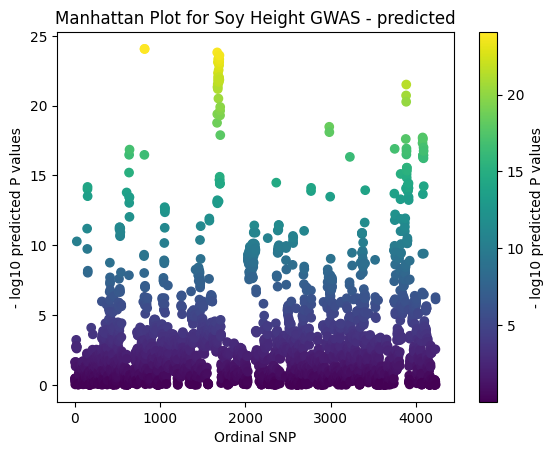

In [25]:

# mark in Kayle as pipeline step: Pipeline step: manhattan_known: Depends on: saliency_known 
model_folder = f"a-{time}-model"
p_values_predicted_np = np.load('p_values_predicted_np.npy',
                               allow_pickle=True)

neg_log = -1 * np.log10(p_values_predicted_np)
slug = np.arange(p_values_predicted_np.shape[0])

pt = plt.scatter(x = slug, y = neg_log, c=neg_log)
plt.title(f"Manhattan Plot for {experiment_description} - predicted")
plt.xlabel("Ordinal SNP")
plt.ylabel("- log10 predicted P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 predicted P values")
plt.savefig(f"{model_folder}-manhattan-predicted")


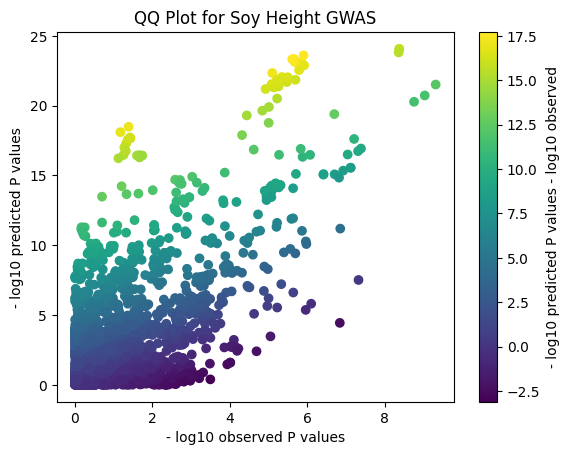

In [24]:

# mark in Kayle as pipeline step: qq plot

model_folder = f"a-{time}-model"

p_values_observed_np = np.load('p_values_observed_np.npy',
                               allow_pickle=True)

neg_log_o = -1 * np.log10(p_values_observed_np)


p_values_predicted_np = np.load('p_values_predicted_np.npy',
                               allow_pickle=True)

neg_log_p = -1 * np.log10(p_values_predicted_np)

pt = plt.scatter(x = neg_log_o, y = neg_log_p, c= neg_log_p - neg_log_o)
plt.title(f"QQ Plot for {experiment_description}")
plt.xlabel("- log10 observed P values")
plt.ylabel("- log10 predicted P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 predicted P values - log10 observed")
plt.savefig(f"{model_folder}-manhattan-predicted")




## There is a second notebook to run after you run this pipeline. Please find the model folder for the best model that Katib found.


In [26]:

print(val_mean_absolute_error)


0.7159170508384705
